# Models

Training and testing models: PSSM, HMM and ensemble of both

In [1]:
# Dependencies
import modules.pssm as pssm
import modules.hmm as hmm
from modules.ensemble import majority_voting
import modules.conf_mat as cmat
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Set matplotlib inline
%matplotlib inline

In [2]:
# Constants
SEQ_FASTA_PATH = 'data/domain.fasta'  # Input sequence (domain)
BLAST_FASTA_PATH = 'data/blast.fasta'  # Get sequence similarity search result
MSA_FASTA_PATH = 'data/msa.edited.fasta'  # Multiple sequence alignment (.fasta)
HUMAN_CSV_PATH = 'data/human.csv'  # Human proteome .csv dataset
HUMAN_FASTA_PATH = 'data/human.fasta'  # Human proteome .fasta dataset
FAMILIES_CSV_PATH = 'data/families.csv'  # Families .csv dataset
# Hidden Markov Model paths
HMMER_MODEL_PATH = 'models/model.hmm'  # Hidden Markov Model path
# PSSM paths
PSSM_MODEL_PATH = 'models/model.pssm'  # PSSM model path
# Results
PSSM_RESULTS_PATH = 'data/results/pssm.tsv'  # PSSM model results
HMMER_RESULTS_PATH = 'data/results/hmmer.tsv'  # HMMER model results
JACK_RESULTS_PATH = 'data/results/jackhmmer.tsv'  # JACKHMMER model results
ENSEMBLE_RESULTS_PATH = 'data/results/ensemble.tsv'  # Ensemble model result
# SITFTS mapping from pdb to uniprot
SIFTS_CSV_PATH = 'data/pdb/pdb_chain_uniprot.tsv'

In [3]:
# Load protein families dataset
human_proteome = pd.read_csv(HUMAN_CSV_PATH, sep='\t')
human_proteome.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
0,Q9Y263,PLAP_HUMAN,Phospholipase A-2-activating protein (PLA2P) (...,795,WD repeat PLAP family,cell [GO:0005623]; cell junction [GO:0030054];...,2K89;2K8A;2K8B;2K8C;3EBB;,PF09070;PF08324;PF00400;,9606.ENSP00000380460;,1.10.150.410;1.25.10.10;2.130.10.10;,False
1,Q96RE7,NACC1_HUMAN,Nucleus accumbens-associated protein 1 (NAC-1)...,527,NaN,cell junction [GO:0030054]; cytoplasm [GO:0005...,3GA1;4U2N;,PF10523;PF00651;,9606.ENSP00000292431;,NaN,False
2,O43312,MTSS1_HUMAN,Protein MTSS 1 (Metastasis suppressor YGL-1) (...,755,MTSS family,actin cytoskeleton [GO:0015629]; cytoplasm [GO...,2D1K;,PF08397;PF02205;,9606.ENSP00000322804;,1.20.1270.60;,False
3,Q9NP80,PLPL8_HUMAN,Calcium-independent phospholipase A2-gamma (EC...,782,NaN,endoplasmic reticulum membrane [GO:0005789]; G...,NaN,PF01734;,9606.ENSP00000410804;,NaN,False
4,Q15319,PO4F3_HUMAN,"POU domain, class 4, transcription factor 3 (B...",338,"POU transcription factor family, Class-4 subfa...",cytoplasm [GO:0005737]; nuclear chromatin [GO:...,NaN,PF00046;PF00157;,9606.ENSP00000230732;,1.10.260.40;,False


In [4]:
# Define function for turning matching ranges into positive positions
def match_to_pos(matches):
    # Define positions container
    positions = list()
    # Check if matches list is empty
    if matches != '':
        # Go through each match
        for dom in matches.split(','):
            # Define start and end of current domain
            dom_start, dom_end = tuple(dom.split('..'))
            # Add current domain's positions
            positions = positions + list(range(int(dom_start), int(dom_end)))
    # Return list of matching positions
    return set(positions)

In [5]:
# Load families positions dataset
protein_matching = pd.read_csv('data/protein_matching.tsv', sep='\t')
protein_matching.columns = ['entry_ac', 'source_db', 'protein_name', 'tax_id',
                              'tax_name', 'len', 'pfam_id', 'matches']
# Take a subset of the original columns
protein_matching = protein_matching[['entry_ac', 'matches']]
# Join protein matching with all the dataset
protein_matching = pd.merge(left=human_proteome[['entry_ac', 'len']],
                            right=protein_matching[['entry_ac', 'matches']],
                            how='left', on='entry_ac')
# Fill na values where there is no domain
protein_matching['matches'] = protein_matching['matches'].fillna('')
# Define real positive matches
protein_matching['positive'] = protein_matching['matches'].apply(match_to_pos)
# Define negative matches
protein_matching['negative'] = protein_matching.apply(lambda x: set(range(1, x['len'])) - x['positive'], axis=1)
# Define a match column: is there the domain in the protein?
protein_matching['match'] = protein_matching.apply(lambda x: len(x['positive']) > 0, axis=1)
# Subset protein matching dataset (only entry with relative positive and negative matches)
protein_matching = protein_matching[['entry_ac', 'match', 'positive', 'negative']]
protein_matching.head()

,entry_ac,match,positive,negative
0,Q9Y263,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,Q96RE7,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,O43312,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,Q9NP80,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,Q15319,False,{},"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [6]:
# Define set of truly positive protein accessions
positive = set(protein_matching[protein_matching['match']]['entry_ac'])
negative = set(human_proteome['entry_ac']) - positive

print('There are {:d} positive and {:d} negative proteins in human proteome'.format(
    len(positive), len(negative)
))

There are 38 positive and 20329 negative proteins in human proteome


## PSSM model

In [7]:
# Execute PSSM
try:
    # Fit the model
    pssm.fit(blast_path=BLAST_FASTA_PATH, msa_path=MSA_FASTA_PATH, model_path=PSSM_MODEL_PATH)
    # Evaluate the model
    pssm_out = pssm.test(model_path=PSSM_MODEL_PATH, test_path=HUMAN_FASTA_PATH,
                         num_iterations=4, e_value=1e-3)
    # Parse pssm results
    pssm_out = pssm.parse(pssm_out)
    # Add positive matches
    pssm_out['positive'] = pssm_out.apply(lambda x: set(range(int(x.seq_start), int(x.seq_end))), axis=1)
    pssm_out = pssm_out.groupby('entry_ac').agg({
        'positive': lambda x: set.union(*x)
    }).reset_index()
    
# Catch error
except subprocess.CalledProcessError as e:
    print(e)
    
# Check pssm result
pssm_out.head()

,entry_ac,positive
0,O00213,"{256, 257, 258, 259, 260, 261, 262, 263, 264, ..."
1,O00308,"{302, 303, 304, 305, 306, 307, 308, 309, 310, ..."
2,O14776,"{130, 131, 132, 133, 134, 135, 136, 137, 138, ..."
3,O15428,"{7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
4,O60828,"{48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5..."


In [8]:
# Define set of positive protein accessions
pssm_positive = set(pssm_out['entry_ac'])
pssm_negative = set(human_proteome['entry_ac']) - pssm_positive

print('There are {:d} positive  and {:d} negative proteins matched by PSSM'.format(
    len(pssm_positive), len(pssm_negative)
))

There are 45 positive  and 20322 negative proteins matched by PSSM


In [9]:
# Define dataset of predicted positive rows
pssm_results = human_proteome[human_proteome.entry_ac.isin(pssm_positive)]
# Save results to disk
pssm_results.to_csv(PSSM_RESULTS_PATH, sep='\t', index=False)
# Show some lines
pssm_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,Short-chain dehydrogenases/reductases (SDR) fa...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,NaN,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,NaN,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,NaN,True


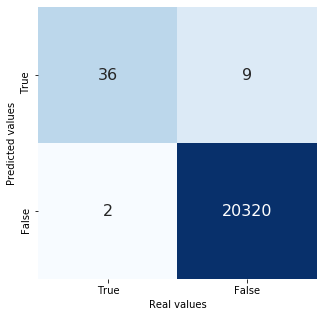

In [10]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=pssm_positive, 
              negative=negative, pred_negative=pssm_negative,
              ax=ax)
_ = plt.show()

## HMMER model

In [11]:
# Execute HMM

# Define e-value threshold
e_value_threshold = 0.7

# Run hmm
try:
    
    # Fit the HMM model
    hmm.fit(msa_path=MSA_FASTA_PATH, model_path=HMMER_MODEL_PATH)
    
    # Evaluate the model
    hmmer_out = hmm.test(test_path=HUMAN_FASTA_PATH, model_path=HMMER_MODEL_PATH, algorithm=hmm.HMMSEARCH)
    hmmer_out = hmm.parse(hmmer_out)
    
    # Make a threshold on e-value
    e_value = hmmer_out['e_value'].astype(float)
    hmmer_out = hmmer_out[e_value < e_value_threshold]
    
    # Add positive matches
    hmmer_out['positive'] = hmmer_out.apply(lambda x: set(range(int(x.seq_start), int(x.seq_end))), axis=1)
    hmmer_out = hmmer_out.groupby('entry_ac').agg({
        'positive': lambda x: set.union(*x)
    }).reset_index()
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)

In [12]:
# Define set of positive protein accessions
hmmer_positive = set(hmmer_out['entry_ac'])
hmmer_negative = set(human_proteome['entry_ac']) - hmmer_positive

print('There are {:d} positive  and {:d} negative proteins matched by HMM'.format(
    len(hmmer_positive), len(hmmer_negative)
))

There are 28 positive  and 20339 negative proteins matched by HMM


In [13]:
# Define dataset of predicted positive rows
hmmer_results = human_proteome[human_proteome.entry_ac.isin(hmmer_positive)]
# Save results to disk
hmmer_results.to_csv(HMMER_RESULTS_PATH, sep='\t', index=False)
# Show some lines
hmmer_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,NaN,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,NaN,True
3679,Q6AWC2,WWC2_HUMAN,Protein WWC2 (BH-3-only member B) (WW domain-c...,1192,WWC family,cytosol [GO:0005829]; kinase binding [GO:00199...,NaN,PF00397;,9606.ENSP00000384222;,2.60.40.150;,True
4895,Q9BYW2,SETD2_HUMAN,Histone-lysine N-methyltransferase SETD2 (EC 2...,2564,Class V-like SAM-binding methyltransferase sup...,chromosome [GO:0005694]; nucleoplasm [GO:00056...,2A7O;2MDC;2MDI;2MDJ;4FMU;4H12;5JJY;5JLB;5JLE;5...,PF17907;PF00856;PF08236;PF00397;,9606.ENSP00000386759;,1.10.1740.100;1.20.930.10;,True


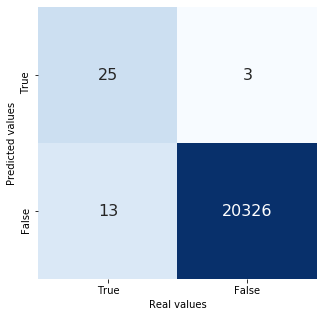

In [14]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=hmmer_positive, 
              negative=negative, pred_negative=hmmer_negative,
              ax=ax)
_ = plt.show()

## JACKHMMER

In [15]:
# Execute HMM

# Define e-value threshold
e_value_threshold = 0.7

# Run hmm
try:
    
    # Evaluate the model
    jack_out = hmm.test(test_path=HUMAN_FASTA_PATH, seq_path=SEQ_FASTA_PATH, algorithm=hmm.JACKHMMER)
    jack_out = hmm.parse(jack_out)
    
    # Make a threshold on e-value
    e_value = jack_out['e_value'].astype(float)
    jack_out = jack_out[e_value < e_value_threshold]
    
    # Add positive matches
    jack_out['positive'] = jack_out.apply(lambda x: set(range(int(x.seq_start), int(x.seq_end))), axis=1)
    jack_out = jack_out.groupby('entry_ac').agg({
        'positive': lambda x: set.union(*x)
    }).reset_index()
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)

In [16]:
# Define set of positive protein accessions
jack_positive = set(jack_out['entry_ac'])
jack_negative = set(human_proteome['entry_ac']) - jack_positive

print('There are {:d} positive  and {:d} negative proteins matched by HMM'.format(
    len(jack_positive), len(jack_negative)
))

There are 49 positive  and 20318 negative proteins matched by HMM


In [17]:
# Define dataset of predicted positive rows
jack_results = human_proteome[human_proteome.entry_ac.isin(jack_positive)]
# Save results to disk
jack_results.to_csv(JACK_RESULTS_PATH, sep='\t', index=False)
# Show some lines
jack_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,Short-chain dehydrogenases/reductases (SDR) fa...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,NaN,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2520,Q5VWI1,TCRGL_HUMAN,Transcription elongation regulator 1-like protein,586,NaN,nucleus [GO:0005634],NaN,PF01846;,9606.ENSP00000357631;,1.10.10.440;,False


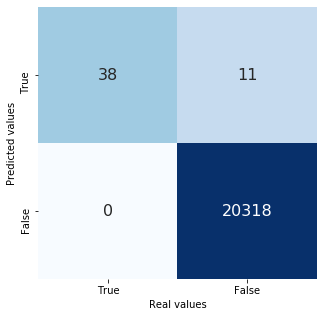

In [18]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=jack_positive, 
              negative=negative, pred_negative=jack_negative,
              ax=ax)
_ = plt.show()

## Ensemble model

Here the ensemble of PSSM and HMM prediction are kept as ensemble model prediction. Then, ensemble model prediction output is evaluated.

In [19]:
# Compute ensemble
ensemble_out = majority_voting([pssm_out, hmmer_out, jack_out], threshold=2)

# Define set of positive protein accessions
ensemble_positive = set(ensemble_out['entry_ac'])
ensemble_negative = set(human_proteome['entry_ac']) - ensemble_positive

print('There are {:d} positive and {:d} negative proteins matched by ensemble method'.format(
    len(ensemble_positive), len(ensemble_negative)
))

There are 47 positive and 20320 negative proteins matched by ensemble method


In [20]:
# Define dataset of predicted positive rows
ensemble_results = human_proteome[human_proteome.entry_ac.isin(ensemble_positive)]
# Save results to disk
ensemble_results.to_csv(ENSEMBLE_RESULTS_PATH, sep='\t', index=False)
# Show some lines
ensemble_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,Short-chain dehydrogenases/reductases (SDR) fa...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,NaN,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,NaN,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,NaN,True


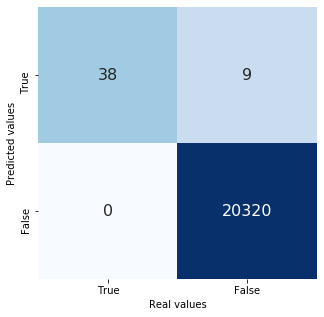

In [21]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=ensemble_positive, 
              negative=negative, pred_negative=ensemble_negative,
              ax=ax)
_ = plt.show()

## Model comparison

Here various metrics are compared for all the different models.

In [22]:
# Define a dictionary model -> predicted positive set
models = {
    'pssm': {
        'positive': pssm_positive, 
        'negative': pssm_negative
    },
    'hmmer': {
        'positive': hmmer_positive,
        'negative': hmmer_negative
    },
    'jackhmmer': {
        'positive': jack_positive,
        'negative': jack_negative
    },
    'ensemble': {
        'positive': ensemble_positive, 
        'negative': ensemble_negative
    }
}

In [23]:
# Compute statistics for each model
for model, attr in models.items():
    # Compute scores for current model (precision, recall, accuracy, weighted accuracy)
    _ , prc, rec, acc, w_acc = cmat.compute(positive=positive, pred_positive=attr['positive'],
                                            negative=negative, pred_negative=attr['negative'])
    # Add scores to each model
    models[model]['prc'] = prc
    models[model]['rec'] = rec
    models[model]['acc'] = acc
    models[model]['w_acc'] = w_acc

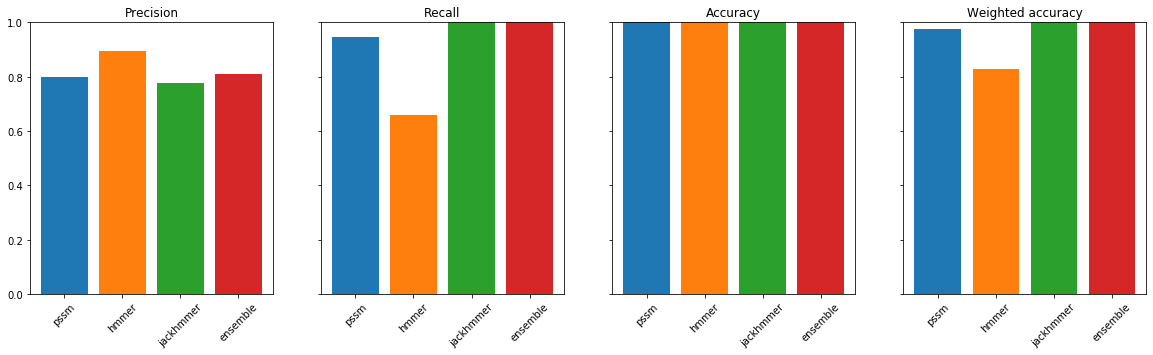

In [24]:
# Show statistics comparison

# Initialize plot: one for each statistic
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
# Define titles for each statistic
_ = axs[0].set_title('Precision')
_ = axs[1].set_title('Recall')
_ = axs[2].set_title('Accuracy')
_ = axs[3].set_title('Weighted accuracy')

# Create a barplot for each statistic
# Fill values for each model
for i, model in enumerate(models.keys()):
    _ = axs[0].bar(i, models[model]['prc'])  # Precision
    _ = axs[1].bar(i, models[model]['rec'])  # Recall
    _ = axs[2].bar(i, models[model]['acc'])  # Accuracy
    _ = axs[3].bar(i, models[model]['w_acc'])  # Weighted accuracy
    
# Set properties for each plot
for i in range(4):
    # Set labels
    _ = axs[i].set_xticks(range(len(models.keys())))
    _ = axs[i].set_xticklabels(list(models.keys()), rotation=45)
    # Set limits
    _ = axs[i].set_ylim(0.0, 1.0)
    
# Show plot
plt.show()

## Sequence matching

In [25]:
# Define different models output
models_out = {
    'pssm': pssm_out,
    'hmmer': hmmer_out,
    'jackhmmer': jack_out,
    'ensemble': ensemble_out
}

In [26]:
# For each model output, define matching sequences

# Define model protein matching container
models_matching = dict()

# loop through each model
for model in models_out.keys():
    
    # Define model output
    model_out = models_out[model]

    # Create dataframe for pssm output comparison
    model_matching = pd.merge(left=model_out, right=protein_matching, 
                              how='left', on='entry_ac', suffixes=('_pred', ''))
    # Fill na values with empty sets
    model_matching = model_matching.fillna('').applymap(lambda x: x if x != '' else set())
    # Handle missing values in positive predictions
    model_matching['positive_pred'] = model_matching['positive_pred'].fillna('').apply(lambda x: x if x != '' else set())
    # Add negative predictions
    model_matching['negative_pred'] = model_matching.apply(lambda x: (x['positive'] | x['negative']) - x['positive_pred'], axis=1)
    # Reorder columns
    model_matching = model_matching[['entry_ac', 'positive', 'negative', 'positive_pred', 'negative_pred']]
    
    # Add statistics columns
    model_matching['prc'], model_matching['rec'], model_matching['acc'], model_matching['w_acc'] = 0, 0, 0, 0
    # Fill statistics for every row
    for i, row in model_matching.iterrows():
        # Compute all the statistics
        _, prc, rec, acc, w_acc = cmat.compute(positive=row['positive'], pred_positive=row['positive_pred'],
                                               negative=row['negative'], pred_negative=row['negative_pred'])
        # Set values
        model_matching.loc[i, 'prc'] = prc
        model_matching.loc[i, 'rec'] = rec
        model_matching.loc[i, 'acc'] = acc
        model_matching.loc[i, 'w_acc'] = w_acc
    
    # Store model matching
    models_matching[model] = model_matching

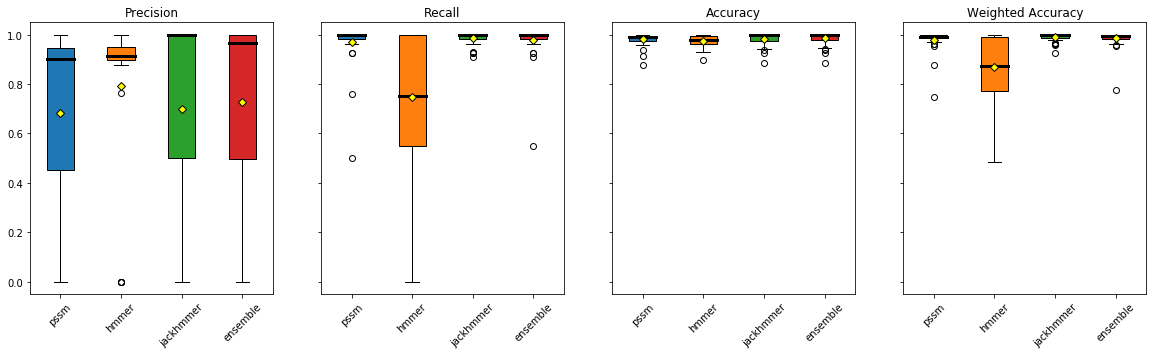

In [27]:
# Show statistics graphically for each model

# Initialize plots (one for each statistic)
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Define columns
cols = [('prc', 'Precision'), ('rec', 'Recall'), ('acc', 'Accuracy'), ('w_acc', 'Weighted Accuracy')]

# Define colors
colors = [*mcolors.TABLEAU_COLORS.values()]

# Set plots attributes
for i, col in enumerate(cols):
    # Get stat and title
    stat, title = col
    # Add title
    _ = axs[i].set_title(title)
    # Create a box for each model
    boxplot = axs[i].boxplot([matching[stat].dropna().tolist() for model, matching in models_matching.items()],
                             medianprops={
                                 'color': 'black',
                                 'linestyle': '-',
                                 'linewidth': 3
                             },
                             meanprops={
                                 'marker': 'D',
                                 'markeredgecolor': 'black',
                                 'markerfacecolor': 'yellow'
                             },
                             meanline=False, showmeans=True, patch_artist=True)
    # Set box labels
    _ = axs[i].set_xticklabels(models_matching.keys(), rotation=45)
    # Set boxplot colours
    for i, box in enumerate(boxplot['boxes']):
        # Change box color
        box.set_facecolor(colors[i])

# Structure matching

In [28]:
# Load SITFS dataset mapping from PDB sequences to UniProt sequences
sifts = pd.read_csv(SIFTS_CSV_PATH, sep='\t', header=1)
# Rename columns
sifts.columns = ['pdb_id', 'chain', 'entry_ac', 'res_beg', 'res_end', 'pdb_beg', 'pdb_end', 'sp_beg', 'sp_end']
# Subset columns:  (keep only pdb id plus the ones mapping to uniprot)
sifts = sifts[['pdb_id', 'chain', 'entry_ac', 'sp_beg', 'sp_end']]
# Rename last columns
sifts.columns = [*sifts.columns[:-2]] + ['seq_start', 'seq_end']
# Group sifts on sequence start and end: various pdb ids map to same areas, but just ine is needed
sifts = sifts.groupby(by=['entry_ac', 'seq_start', 'seq_end']).agg({
    'pdb_id': lambda pdb_ids: pdb_ids.values[0]
}).reset_index()
# Join with human proteome in order to retrieve length of the whole sequence
sifts = sifts.merge(human_proteome[['entry_ac', 'len']], on='entry_ac', how='inner')
# Redefine sequence interval as set of positions
sifts['positive'] = sifts.apply(lambda x: set(range(x['seq_start'], x['seq_end'])), axis=1)
sifts['negative'] = sifts.apply(lambda x: set(range(1, x['len'])) - x['positive'], axis=1)
# Remove useless columns
sifts = sifts[['entry_ac', 'pdb_id', 'positive', 'negative']]
sifts.head()

,entry_ac,pdb_id,positive,negative
0,A0A075B6N1,5hhm,"{21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,A0A075B6N1,5hho,"{21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,A0A075B6N1,5nqk,"{22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,A0A075B6T6,1ao7,"{23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,A0A075B6T6,4zdh,"{24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [29]:
# Recompute ensemble model
ensemble_out = majority_voting([pssm_out, hmmer_out, jack_out], threshold=2)
ensemble_out.head()

,entry_ac,positive
0,O00213,"{256, 257, 258, 259, 260, 261, 262, 263, 264, ..."
1,O00308,"{302, 303, 304, 305, 306, 307, 308, 309, 310, ..."
2,O14776,"{137, 138, 139, 140, 141, 142, 143, 144, 145, ..."
3,O15428,"{7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
4,O60828,"{48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5..."


In [30]:
# Join model output with sifts
# Note that inner join has been used: we want to get only those PDBs which best match the sequences
structure_matching = pd.merge(left=ensemble_out, right=sifts, how='inner', on='entry_ac', suffixes=('', '_pred'))
structure_matching.columns=['entry_ac', 'positive', 'pdb_id', 'positive_pred', 'negative_pred']
# Add negative column
structure_matching['negative'] = structure_matching.apply(lambda x: (x['positive_pred'] | x['negative_pred']) - x['positive_pred'], axis=1)
# Add precision statistics to each match
structure_matching['prc'] = 0

# Loop through each row
for i, row in structure_matching.iterrows():
    # Compute statistics
    _ , prc, rec, acc, w_acc = cmat.compute(positive=row['positive'], pred_positive=row['positive_pred'],
                                            negative=row['negative'], pred_negative=row['negative_pred'])
    # Save statistics
    structure_matching.loc[i, 'prc'] = prc

# Reorder columns
structure_matching = structure_matching[['entry_ac', 'pdb_id', 'positive', 'negative', 'positive_pred', 'negative_pred', 'prc']]
# Show result
structure_matching.head()

,entry_ac,pdb_id,positive,negative,positive_pred,negative_pred,prc
0,O00213,2e45,"{256, 257, 258, 259, 260, 261, 262, 263, 264, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{256, 257, 258, 259, 260, 261, 262, 263, 264, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0
1,O00213,2ho2,"{256, 257, 258, 259, 260, 261, 262, 263, 264, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{256, 257, 258, 259, 260, 261, 262, 263, 264, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0
2,O00213,3d8d,"{256, 257, 258, 259, 260, 261, 262, 263, 264, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{366, 367, 368, 369, 370, 371, 372, 373, 374, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN
3,O00213,3dxc,"{256, 257, 258, 259, 260, 261, 262, 263, 264, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{534, 535, 536, 537, 538, 539, 540, 541, 542, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN
4,O00308,6j1z,"{302, 303, 304, 305, 306, 307, 308, 309, 310, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{384, 385, 386, 387, 388, 389, 390, 391, 392, ...","{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0
